In [ ]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git
%cd uni2ts
!pip install -e .

In [2]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from uni2ts.model.moirai import MoiraiForecast, MoiraiMoEModule
from uni2ts.eval_util.data import get_custom_eval_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from eval_utils import *

In [3]:
# Eval params
benchmark_folder = 'benchmark_eval_data'
results_folder = 'benchmark_eval_results'
target_col = 'Adj Close'
eval_start = '2020-01-01'  # start eval period
eval_end = '2024-10-01'  # end eval period
device = 'cuda'  # choose from 'cuda' or 'cpu'

In [4]:
datasets_dict = load_datasets_from_folder(benchmark_folder)
print(datasets_dict.keys())

dict_keys(['DOT', 'AMZN', 'Corn', 'PFE', 'Copper', 'Sugar', 'LTC', 'BTC', 'TSLA', 'Wheat', 'WMT', 'DIS', 'NFLX', 'HD', 'Brent_Crude_Oil', 'ADA', 'MATIC', 'S&P500', 'FB', 'SOL', 'XRP', 'WTI_Crude_Oil', 'Soybeans', 'Gold', 'XOM', 'ETH', 'AAPL', 'Natural_Gas', 'BA', 'Coffee', 'GOOGL', 'PEP', 'RUSSELL2000', 'NKE', 'MSFT', 'T', 'JNJ', 'VZ', 'Silver', 'NASDAQ_COMPOSITE'])


In [5]:
# Model params
size = "small"  # choose from "small", "base", "large"
use_x = True  # use X covariates or not
CTX = 300  # context length: how many past values to use to make predictions
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 1  # batch size
PDT = 1  # prediction length
offset = None  # point in the timeseries from where to start predictions
windows = None  # number of prediction window
dist = 1  # dist between each window
model_name = f'moirai-MoE_{size}'
#model_path = f'Salesforce/moirai-moe-1.0-R-{size}'
model_path = f'../moirai_moe_{size}'

In [36]:
def generate_model(size, pdt, ctx, psz, fdrm, device, num_samples=100):
    model = MoiraiForecast(
        module=MoiraiMoEModule.from_pretrained(model_path),
        mode="autoregressive",
        prediction_length=pdt,
        context_length=ctx,
        patch_size=16,
        num_samples=num_samples,
        target_dim=1,
        feat_dynamic_real_dim=fdrm,
        past_feat_dynamic_real_dim=0,
    ).to(device)
    return model

In [37]:
results_dict = {}

for key, df in datasets_dict.items():
    covariates = [col for col in df.columns if col != target_col]
    test_set_points = len(df[(df.index >= eval_start) & (df.index < eval_end)])
    df = df[df.index < eval_end]
    print(f"Test set len for {key}: {test_set_points}")

    offset = -test_set_points
    windows = test_set_points
    train_data, test_data, ds = prepare_ds_dataset(df, covariates, target_col, offset, PDT, windows, dist)

    model = generate_model(size, pdt=PDT, ctx=CTX, psz=PSZ, fdrm=ds.num_feat_dynamic_real, device=device, num_samples=100)
    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = list(predictor.predict(test_data.input))

    preds = np.array([f.mean[0] for f in forecasts])
    pred_series = pd.Series(data=[pred.item() for pred in preds], index=df.index[-windows:])
    real_value_series = pd.Series(data=df[target_col][-windows:], index=df.index[-windows:])

    results_dict[key] = (pred_series, real_value_series)

Test set len for DOT: 50
Loading weights from local directory
Test set len for AMZN: 57
Loading weights from local directory
Test set len for Corn: 57
Loading weights from local directory
Test set len for PFE: 57
Loading weights from local directory
Test set len for Copper: 57
Loading weights from local directory
Test set len for Sugar: 57
Loading weights from local directory
Test set len for LTC: 57
Loading weights from local directory
Test set len for BTC: 57
Loading weights from local directory
Test set len for TSLA: 57
Loading weights from local directory
Test set len for Wheat: 57
Loading weights from local directory
Test set len for WMT: 57
Loading weights from local directory
Test set len for DIS: 57
Loading weights from local directory
Test set len for NFLX: 57
Loading weights from local directory
Test set len for HD: 57
Loading weights from local directory
Test set len for Brent_Crude_Oil: 57
Loading weights from local directory
Test set len for ADA: 57
Loading weights from lo

In [38]:
from tabulate import tabulate
import numpy as np

# Prepare data for tabulation in a single loop
table_data = []
headers = ['Dataset', 'MSE', 'MAE', 'MAPE (%)', 'Directional Accuracy']

# Initialize lists to store metric values for averaging
mse_values = []
mae_values = []
mape_values = []
directional_accuracy_values = []

for dataset_name, (preds, reals) in results_dict.items():
    # Compute metrics
    mse, mae, mape, directional_accuracy = compute_metrics(preds, reals)

    # Append metrics to the table data
    table_data.append([
        dataset_name,
        f"{mse:.4f}",
        f"{mae:.4f}",
        f"{mape:.4f}",
        f"{directional_accuracy:.4f}"
    ])

    # Store metrics for averaging
    mse_values.append(mse)
    mae_values.append(mae)
    mape_values.append(mape)
    directional_accuracy_values.append(directional_accuracy)

# Compute averages for each metric
avg_mse = np.mean(mse_values)
avg_mae = np.mean(mae_values)
avg_mape = np.mean(mape_values)
avg_directional_accuracy = np.mean(directional_accuracy_values)

# Append average metrics to the table data
table_data.append([
    "Average",
    f"{avg_mse:.4f}",
    f"{avg_mae:.4f}",
    f"{avg_mape:.4f}",
    f"{avg_directional_accuracy:.4f}"
])

# Print the metrics in tabular format
print(tabulate(table_data, headers=headers, tablefmt='grid'))


+------------------+------------------+-----------+------------+------------------------+
| Dataset          |              MSE |       MAE |   MAPE (%) |   Directional Accuracy |
+==================+==================+===========+============+========================+
| DOT              |     36.7139      |    4.0537 |    30.914  |                 0.4082 |
+------------------+------------------+-----------+------------+------------------------+
| AMZN             |    160.879       |   10.0574 |     7.5222 |                 0.5357 |
+------------------+------------------+-----------+------------+------------------------+
| Corn             |      1.3769      |    0.8856 |     4.368  |                 0.5714 |
+------------------+------------------+-----------+------------+------------------------+
| PFE              |      7.9748      |    2.2141 |     6.1992 |                 0.4821 |
+------------------+------------------+-----------+------------+------------------------+
| Copper  

In [39]:
import pickle

os.makedirs(results_folder, exist_ok=True)
output_file = os.path.join(results_folder, f'{model_name}_metrics.pkl')
with open(output_file, 'wb') as file:
    pickle.dump(results_dict, file)
print(f"Results dictionary saved to '{output_file}'")

Results dictionary saved to 'benchmark_eval_results/moirai-MoE_small_metrics.pkl'


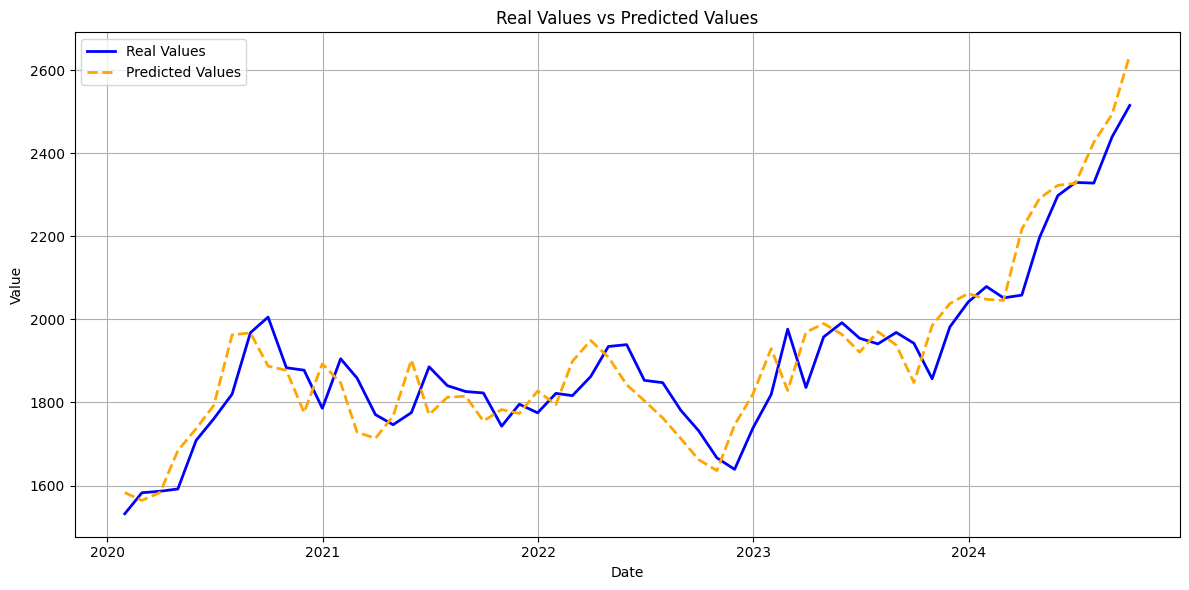

In [42]:
a, b = results_dict['Gold']
plot_real_vs_predicted(a, b)